In [ ]:
# Utils
import pandas as pd
import numpy as np
import json
import os
import subprocess
import zipfile
import IPython.display as ipd
from pathlib import Path
from collections import Counter

# Library for audio processing
import librosa
import librosa.display
import soundfile as sf
from scipy.io.wavfile import write

# Visualizations and plots
import matplotlib.pyplot as plt

# Options
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None

# Warnings
import warnings
warnings.filterwarnings('ignore', '.*PySoundFile failed. Trying audioread instead*.', )

# Colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Feature extractors

# Feature extractor for MFCC only
def mfcc_extractor(input):
  mfcc = librosa.feature.mfcc(input, n_mfcc=15, n_fft=2048, hop_length=512)
  return mfcc

# Feature extractor for MFCC and their derivatives
def complete_extractor(input):
  mfcc = librosa.feature.mfcc(input, n_mfcc=15, n_fft=2048, hop_length=512)
  mfcc_delta = librosa.feature.delta(mfcc)
  mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
  feats = np.stack((mfcc, mfcc_delta, mfcc_delta2))
  return feats

After applying data augmentation on the raw signal, the audio features for classification are generated. The parameters for generating the coefficients are taken from the paper of the winning group of the DiCOVA19 challenge.

# Example

In [ ]:
audio_path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Example/audiopreprocessed_example.wav'
audio, sr = librosa.load(audio_path)
ipd.Audio(audio, rate = sr)

In [ ]:
features = complete_extractor(audio)

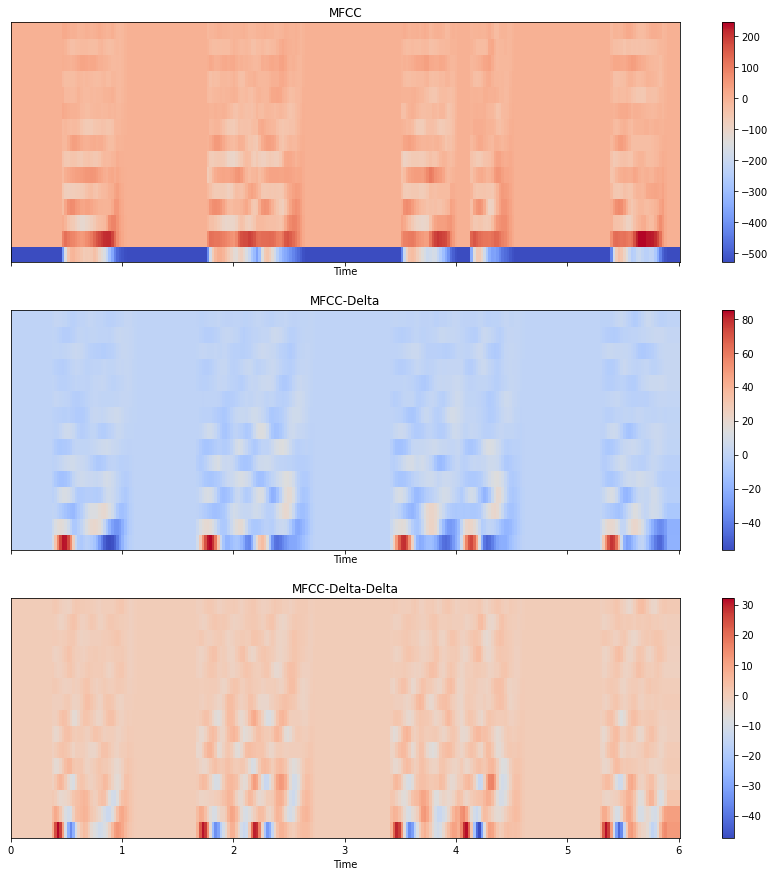

In [ ]:
fig, ax = plt.subplots(nrows=3, figsize=(15, 15), sharex=True, sharey=True)
mfcc = librosa.display.specshow(features[0], x_axis='time', ax=ax[0])
ax[0].set(title='MFCC')
fig.colorbar(mfcc, ax=[ax[0]])
mfcc_delta = librosa.display.specshow(features[1], x_axis='time', ax=ax[1])
ax[1].set(title='MFCC-Delta')
fig.colorbar(mfcc_delta, ax=[ax[1]])
mfcc_delta2 = librosa.display.specshow(features[2], x_axis='time', ax=ax[2])
ax[2].set(title='MFCC-Delta-Delta')
fig.colorbar(mfcc_delta2, ax=[ax[2]])

# Feature extraction

## Full dataset

In [ ]:
# Data loader
def feature_extractor_BI2(extractor, tracks, original_path, augmented_path):
    labels = []
    features = []
    counter = 0

    for index, row in tracks.iterrows():
      if row['uuid'].startswith('aug_'):
        tmp_audio, tmp_sr = librosa.load(augmented_path+row['uuid'])
      else:
        tmp_audio, tmp_sr = librosa.load(original_path+row['uuid'])

      tmp_features = extractor(tmp_audio)
      features.append(tmp_features)

      tmp_class = row['COVID19_BI_2']
      labels.append(tmp_class)

      counter += 1
      if counter%1000==0:
        print('Processed: ' + str(counter) + '/' + str(tracks.shape[0]))

    return features, labels

In [ ]:
audioBI2 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugBeforeSplit/complete_audiotracks.csv')
audioBI2 = audioBI2.drop(['Unnamed: 0'], axis = 1)

In [ ]:
original_path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Dataset/AudioNoNoise/'
aug_path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Dataset/AugmentedData/FinalVersion/AugAllDataset/'

In [ ]:
# MFCC extraction
# features_BI2, labels_BI2 = feature_extractor_BI2(mfcc_extractor, audioBI2, original_path, aug_path)

# Extraction of MFCC and derivatives
features_BI2, labels_BI2 = feature_extractor_BI2(complete_extractor, audioBI2, original_path, aug_path)

Processed: 1000/15184
Processed: 2000/15184
Processed: 3000/15184
Processed: 4000/15184
Processed: 5000/15184
Processed: 6000/15184
Processed: 7000/15184
Processed: 8000/15184
Processed: 9000/15184
Processed: 10000/15184
Processed: 11000/15184
Processed: 12000/15184
Processed: 13000/15184
Processed: 14000/15184
Processed: 15000/15184


In [ ]:
# feat_path_BI2 = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugBeforeSplit/mfcc_features.npy'
# labels_path_BI2 = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugBeforeSplit/mfcc_labels.npy'

feat_path_BI2 = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugBeforeSplit/complete_features.npy'
labels_path_BI2 = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugBeforeSplit/complete_labels.npy'

np.save(feat_path_BI2, features_BI2)
np.save(labels_path_BI2, labels_BI2)

## Split

In [ ]:
# Data loader
def feature_extractor_test(extractor, tracks, original_path):
    labels = []
    features = []
    counter = 0

    for index, row in tracks.iterrows():
      tmp_audio, tmp_sr = librosa.load(original_path+row['uuid'])

      tmp_features = extractor(tmp_audio)
      features.append(tmp_features)

      tmp_class = row['COVID19_BI_2']
      labels.append(tmp_class)

      counter += 1
      if counter%1000==0:
        print('Processed: ' + str(counter) + '/' + str(tracks.shape[0]))

    return features, labels

In [ ]:
train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugAfterSplit/complete_audiotracks_train.csv')
train = train.drop(['Unnamed: 0'], axis = 1)

In [ ]:
test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugAfterSplit/original_test.csv')
test = test.drop(['Unnamed: 0'], axis = 1)

In [ ]:
original_path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Dataset/AudioNoNoise/'
aug_path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Dataset/AugmentedData/FinalVersion/Split/Train/'

In [ ]:
# MFCC extraction
# features_train, labels_train = feature_extractor_BI2(mfcc_extractor, train, original_path, aug_path)

# Extraction of MFCC and derivatives
features_train, labels_train = feature_extractor_BI2(complete_extractor, train, original_path, aug_path)

Processed: 1000/12145
Processed: 2000/12145
Processed: 3000/12145
Processed: 4000/12145
Processed: 5000/12145
Processed: 6000/12145
Processed: 7000/12145
Processed: 8000/12145
Processed: 9000/12145
Processed: 10000/12145
Processed: 11000/12145
Processed: 12000/12145


In [ ]:
print(Counter(labels_train))

Counter({'Negative': 9205, 'Positive': 2940})


In [ ]:
# features_train_path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugAfterSplit/mfcc_features_train.npy'
# labels_train_path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugAfterSplit/mfcc_labels_train.npy'

features_train_path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugAfterSplit/complete_features_train.npy'
labels_train_path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugAfterSplit/complete_labels_train.npy'

np.save(features_train_path, features_train)
np.save(labels_train_path, labels_train)

In [ ]:
# MFCC extraction
# features_test, labels_test = feature_extractor_test(mfcc_extractor, test, original_path)

# Extraction of MFCC and derivatives
features_test, labels_test = feature_extractor_test(complete_extractor, test, original_path)

Processed: 1000/2424
Processed: 2000/2424


In [ ]:
print(Counter(labels_test))

Counter({'Negative': 2301, 'Positive': 123})


In [ ]:
# features_test_path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugAfterSplit/mfcc_features_test.npy'
# labels_test_path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugAfterSplit/mfcc_labels_test.npy'

features_test_path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugAfterSplit/complete_features_test.npy'
labels_test_path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugAfterSplit/complete_labels_test.npy'

np.save(features_test_path, features_test)
np.save(labels_test_path, labels_test)